# PCA 範例
* 以 PCA + 邏輯斯迴歸判斷手寫辨識資料集, 觀察不同 component 下正確率的變化

In [1]:
# 載入套件
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# 作業
* 將參數 penalty 改為 L1, max_iter 改為 100, 觀察 PCA 與羅吉斯迴歸做手寫辨識的效果

In [2]:
# 定義 PCA 與隨後的羅吉斯迴歸函數
# penalty 改為 L1, max_iter 改為 100
logistic = SGDClassifier(loss='log', penalty='l1', max_iter=100, tol=1e-5, random_state=0)
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# 載入手寫數字辨識集
digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

### Sklearn的pipeline
![](http://frankchen.xyz/images/15231783974167.jpg)

> http://frankchen.xyz/2018/04/08/pipeline-in-machine-learning/

### Sklearn的PCA
PCA()中的n_components_ ，表示降成幾維

pca fit後的explained_variance_ratio_ ，為保留下來的信息量比率

> https://blog.csdn.net/lanchunhui/article/details/50521648

> https://blog.csdn.net/u012162613/article/details/42192293

In [3]:
# 執行 GridSearchCV 跑出最佳參數
param_grid = {
    'pca__n_components': [4, 10, 20, 30, 40, 50, 64],
    'logistic__alpha': np.logspace(-4, 4, 5),
}
search = GridSearchCV(pipe, param_grid, iid=False, cv=5, return_train_score=False)
search.fit(X_digits, y_digits)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)
print("Avg. time to fit: {:.3f}".format(search.cv_results_['mean_fit_time'].mean()))
print("Avg. time to predict: {:.3f}".format(search.cv_results_['mean_score_time'].mean()))

Best parameter (CV score=0.913):
{'logistic__alpha': 0.01, 'pca__n_components': 20}
Avg. time to fit: 0.121
Avg. time to predict: 0.000


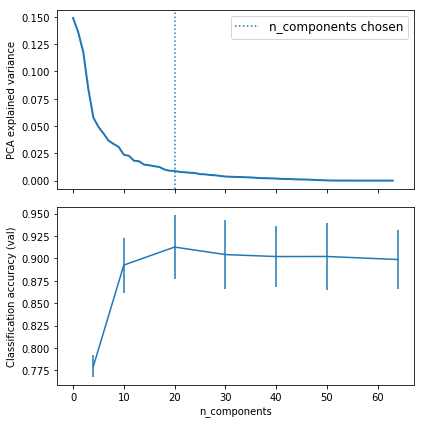

In [6]:
# 繪製不同 components 的 PCA explained variance ratio
pca.fit(X_digits)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(pca.explained_variance_ratio_, linewidth=2)
ax0.set_ylabel('PCA explained variance')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components, linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# 繪製不同採樣點的 accuracy
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score', legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')
plt.tight_layout()